# Preprocessing and Data Visualization

### Preamble: Settings Django Environment

**Note**: This notebook assumes **Python 3** as the running interpreter

In [1]:
%load preamble_directives.py

# Load Data

### Import Target Projects

In [2]:
from source_code_analysis.models import SoftwareProject
projects = list()
projects.append(SoftwareProject.objects.get(name__iexact='CoffeeMaker', version__exact='1.0'))
projects.append(SoftwareProject.objects.get(name__iexact='Jfreechart', version__exact='0.6.0'))
projects.append(SoftwareProject.objects.get(name__iexact='Jfreechart', version__exact='0.7.1'))
projects.append(SoftwareProject.objects.get(name__iexact='JHotDraw', version__exact='7.4.1'))
print(projects)

[<SoftwareProject: CoffeeMaker (1.0)>, <SoftwareProject: JFreeChart (0.6.0)>, <SoftwareProject: JFreeChart (0.7.1)>, <SoftwareProject: JHotDraw (7.4.1)>]


## Import Labeled Data

In [3]:
from coherence_dataset.models import Example
examples = Example.objects.all()
print('Total Examples in Dataset: ', examples.count())

Total Examples in Dataset:  2881


### Statistics per Project

In [4]:
from coherence_dataset.settings import COHERENT, NOT_COHERENT
total_positive_count, total_negative_count = 0, 0

# Header
print('\t\t\t Positive \t Negative \t Total')
print('-'*63)
# Per-Project Counts
for project in projects:
    data = examples.filter(method__project__id=project.id)
    positive_count = data.filter(target=COHERENT).count()
    negative_count = data.filter(target=NOT_COHERENT).count()
    # Increment Total Counters
    total_positive_count += positive_count
    total_negative_count += negative_count
    print('{0} \t {1} \t\t {2} \t\t {3}'.format(str(project), positive_count, negative_count, 
                                                positive_count+negative_count))
# Total count
print('-'*63)
print('Total \t\t\t {0} \t\t {1} \t\t {2}'.format(total_positive_count, total_negative_count,
                                                  total_positive_count+total_negative_count))

			 Positive 	 Negative 	 Total
---------------------------------------------------------------
CoffeeMaker (1.0) 	 27 		 20 		 47
JFreeChart (0.6.0) 	 406 		 55 		 461
JFreeChart (0.7.1) 	 520 		 68 		 588
JHotDraw (7.4.1) 	 760 		 1025 		 1785
---------------------------------------------------------------
Total 			 1713 		 1168 		 2881


## Preprocessing

### Load Dataset (Feature Extraction)

Textual data stored in the database requires to be properly represented in the considered **Feature Space**, i.e. the **Vector Space Model** (VSM).
To this end, we will build a processing *pipeline* (`sklearn.pipeline.Pipeline`) that consists of two processing step:

1. Converting the collection of text documents to a matrix of token counts (`sklearn.feature_extraction.text.CountVectorizer`);
2. Transform the resulting count matrix to a normlized `tfidf` representation (`sklearn.feature_extraction.text.TfidfTransformer`)

All the required logic is embedded in the `coherence.load_coherence_dataset` function.

#### Implementation Notes:
The actual formula used for `tf-idf` (under the hood) is 
$$tf * (idf + 1) = tf + tf * idf$$
The effect is that terms with zero $idf$, i.e. those occurring in all documents of the collection, 
will not be entirely ignored.

Moreover, the specific formulas used to compute $tf$ and $idf$ 
depend on parameter passed to the `Pipeline` object.

The list of used parameters are: 

* **`sublinear_tf=True`** ==>  $tf$ will be calculated as $tf = 1 + \ln tf$. 

    This formulation of the $tf$ should be less sensible to (numerical) outliers, which could 
    possibly be the case in our dataset, where only few terms are involved in the calculation.
    
    
* **`use_idf=True`**  ==> actually computes *tfidf* for features (instead of just *tf*)


* **`norm='l2'`**  ==> $L_2$ normalization is applied to data, i.e. resulting vectors are length-normalised.


* **`lowercase=False`**  ==> Avoid changing data to lowercase (as they're still so, in the DB)


* **`stop_words=None`**  ==> No stopword list is passed, as *raw* textual data in the DB has been already processed in 
    a "standard" IR-indexing pipeline (i.e. lowercase + stop_word filtering + stemming (Porter)).



### Note:
The *cut-off* parameter (i.e. `min_df`) could be considered for inclusion, in case we would filter out terms that occur less than a minimum number of documents.

In [5]:
from coherence import load_coherence_dataset

In [6]:
coherence_ds = load_coherence_dataset()

In [7]:
print(coherence_ds.DESCR)

The Coherence dataset contains information about the 
coherence between the head comment and the implementation
of a source code methods.

=================   ==============
Classes                          2
Samples per class       (Pos) 1713
(Neg) 1168
Samples total           (Tot) 2881
Dimensionality                5642
Unique Terms                  2821
Features            real, positive
=================   ==============

Note:
-----
Since methods are gathered from different software projects, to ease data
analysis (e.g. slicing, splitting or extracting data of a single software project), 
data are stored according to class and project, respectively.
In particular, data are primarily grouped by classes (all positive instances, first), and then
further organized per project.

So far, these are the distribution of examples per single project:
======================   ===========================
Project                  Positive | Negative | Total
CoffeeMaker (1.0)           27    | 

In [8]:
X, y = coherence_ds.data, coherence_ds.target

In [9]:
print(X.shape)
print(y.shape)

(2881, 5642)
(2881,)


In [10]:
## Statistics on the dataset for each project
for project in coherence_ds.projects['names']:
    info = coherence_ds.projects[project]
    print('Project: {0} {1}'.format(info['name'], info['version']), end=' '*4)
    print('Positive={0}; Negative={1}'.format(info['positive_examples'],
                                              info['negative_examples']))

Project: CoffeeMaker 1.0    Positive=(0, 27); Negative=(1713, 1733)
Project: Jfreechart 0.6.0    Positive=(27, 433); Negative=(1733, 1788)
Project: Jfreechart 0.7.1    Positive=(433, 953); Negative=(1788, 1856)
Project: JHotDraw 7.4.1    Positive=(953, 1713); Negative=(1856, 2881)


In [11]:
coherence_ds.target_counts

(1713, 1168)

# Feature Reduction and Data Visualization

Since we are in a **Feature Space** consisting of `5642` dimensions, we need some *trick* to 
reduce the dimension in order to plot the data.

In the next sections, two dimensions for feature reduction will be considered:

* Principal Component Analysis (PCA)
* Manifold Learning

To visualise the data, 2D and 3D **Scatter plots** will be created, leveraging on the `matplotlib` library. 
Moreover, an **interactive** (2D) scatter plot using **Bokeh** will be also included, to easely inspect
resulting data points.

### Plot utilities functions

Functions to generate 2D and 3D scatter plots using `matplotlib`.

These functions will be invoked multiple times, depending on the *feature reduction* strategy 
applied to data.

In [12]:
import matplotlib.pyplot as plt
import matplotlib

In [13]:
%matplotlib inline

In [14]:
pos_offset, _ = coherence_ds.target_counts
class_labels = coherence_ds.target_names

In [15]:
## 2D Scatter plot with matplotlib
def scatter_2D(data, offset, labels):
    """Generate and show a 2D scatter plot of input data.

    Input data are assumed to be separated in two classes.
    
    Parameters
    ----------
    data : list (or numpy array)
        Array of data to plot
        
    offset : integer
        Index of separating classes
        
    labels : tuple
        List of the two considered class names
    """
    matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
    fig = plt.figure()
    cl1_label, cl2_label = labels
    plt.scatter(data[0:offset,0], data[0:offset,1], c='green', 
                marker='o', label=cl1_label, s=60)
    plt.scatter(data[offset:,0], data[offset:,1], c='red', 
                marker='*', label=cl2_label, s=60)
    plt.legend()
    plt.show()

In [16]:
## 3D Scatter plot with matplotlib
from mpl_toolkits.mplot3d import Axes3D

def scatter_3D(data, offset, labels):
    """Generate and show a 3D scatter plot of input data.

    Input data are assumed to be separated in two classes.
    
    Parameters
    ----------
    data : list (or numpy array)
        Array of data to plot
        
    offset : integer
        Index of separating classes
        
    labels : tuple
        List of the two considered class names
    """
    matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    cl1_label, cl2_label = labels
    ax.scatter(data[0:offset,0], data[0:offset,1], data[0:offset,1], 
               c='green', marker='o', label=cl1_label, s=60)
    ax.scatter(data[offset:,0], data[offset:,1], data[offset:,1], 
               c='red', marker='*', label=cl2_label, s=60)

    plt.legend()
    plt.show()

## Feature Reduction no. 1 : PCA

**PCA** is a linear dimensionality reduction technique based on the SVD (Singular Value Decomposition) of the data.
The technique aims at keeping only the most significant *singular vectors* to project the data to a lower dimensional space.

The time complexity of the current (underlying) implementation is 
$O(n ^ 3)$ assuming `n` $\propto$ `n_samples` $\propto$ `n_features`.

In [17]:
from sklearn.decomposition import PCA

### PCA(k=2)
Projecting the data to a 2-dimensional space (i.e. `n_components=2`)

In [18]:
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
X_PCA2 = pca.transform(X_dense)

### 2D Scatter Plot

/Users/valerio/anaconda/envs/code_comments_analysis/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


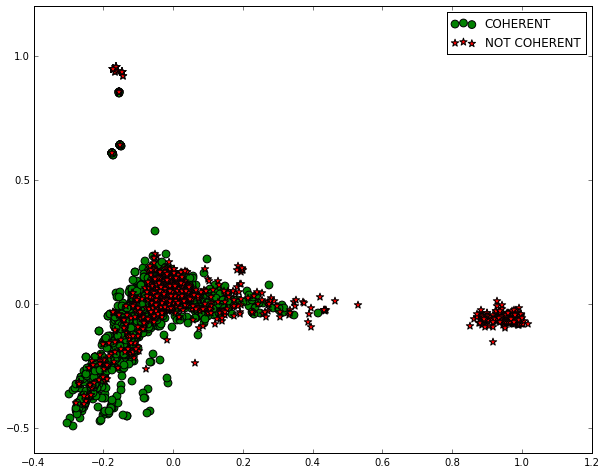

In [19]:
scatter_2D(X_PCA2, pos_offset, class_labels)

### PCA(k=3)
Projecting the data to a 3-dimensional space (i.e. `n_components=3`)

In [20]:
pca = PCA(n_components=3).fit(X_dense)
X_PCA3 = pca.transform(X_dense)

### 3D Scatter Plot

/Users/valerio/anaconda/envs/code_comments_analysis/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


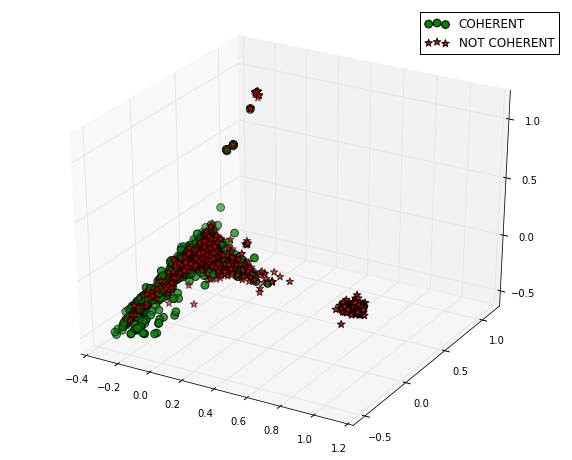

In [21]:
scatter_3D(X_PCA3, pos_offset, class_labels)

## Feature Reduction no. 2 : Manifold

### 2.1 Isomap

One of the earliest approaches to manifold learning is the **Isomap algorithm**, 
(short for **Isometric Mapping**). 

Isomap can be viewed as an extension of Multi-dimensional Scaling (MDS) or Kernel PCA. 

Isomap seeks a lower-dimensional embedding which maintains geodesic distances between all points. 
Isomap can be performed with the object `sklearn.manifold.Isomap`.

Please see the [`Isomap` documentation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap) for further details.

### Isomap 2 Dimensions

In [23]:
from sklearn.manifold import Isomap
from scipy.stats.mstats import mquantiles

# Parameter settings
k = 10  # number of nearest neighbors to consider
d = 2  # dimensionality
X_Isomap_2d = Isomap(k, d, eigen_solver='auto').fit_transform(X.toarray())

### 2D Scatter Plot - Isomap

/Users/valerio/anaconda/envs/code_comments_analysis/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


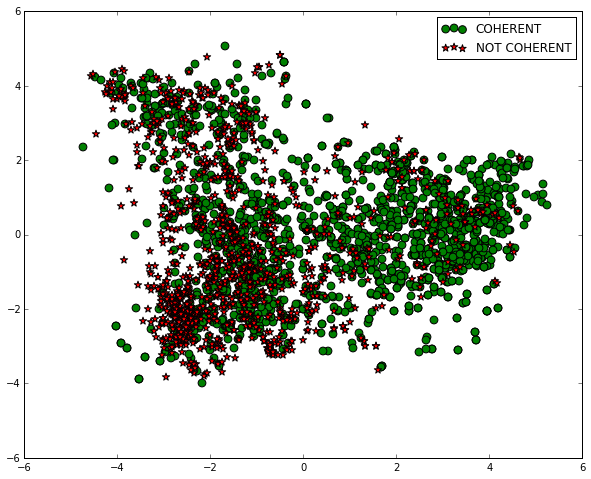

In [24]:
scatter_2D(X_Isomap_2d, pos_offset, class_labels)

### Isomap 3 Dimensions

In [25]:
d = 3  # 3 dimensions
X_Isomap_3d = Isomap(k, d, eigen_solver='auto').fit_transform(X.toarray())

### 3D Scatter Plot - Isomap

/Users/valerio/anaconda/envs/code_comments_analysis/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


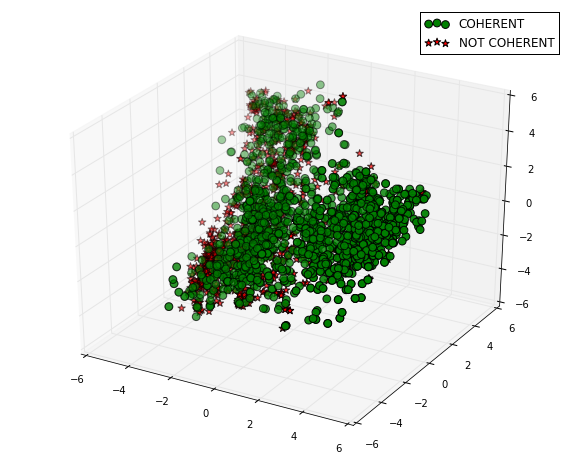

In [26]:
scatter_3D(X_Isomap_3d, pos_offset, class_labels)

### 2.2 t-SNE

t-Distributed Stochastic Neighbor Embedding ([t-SNE](http://lvdmaaten.github.io/tsne/)) is a 
technique for dimensionality reduction that is particularly well suited for the visualization of 
high-dimensional datasets.

The t-SNE technique converts similarities between data points to joint probabilities, and tries
to minise the `Kullback-Leibler` divergence between the joint probabilities of the low-dimensional embedding 
and the high-dimensional data. 

The (main) "drawback" of t-SNE is that it has a cost function that is **not** convex, thus 
different initialisations can lead to different results.

Please see the [`TSNE` documentation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE) for further details.

In [27]:
from sklearn.manifold import TSNE

For high-dimensional sparse data it is helpful to first reduce the dimensions to 50 dimensions with TruncatedSVD and then perform t-SNE. This will usually improve the visualization.

In [28]:
from sklearn.decomposition import TruncatedSVD
X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(X)

### t-SNE 2 dimensions

In [29]:
X_tsne_2d = TSNE(n_components=2, perplexity=40).fit_transform(X_reduced)

### 2D Scatter Plot - t-SNE

/Users/valerio/anaconda/envs/code_comments_analysis/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


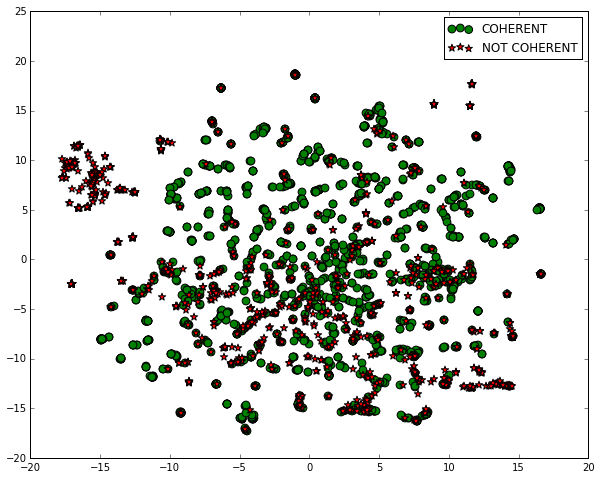

In [30]:
scatter_2D(X_tsne_2d, pos_offset, class_labels)

### t-SNE 3 dimensions

In [31]:
X_tsne_3d = TSNE(n_components=3, perplexity=40).fit_transform(X_reduced)

### 3D Scatter Plot - t-SNE

/Users/valerio/anaconda/envs/code_comments_analysis/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


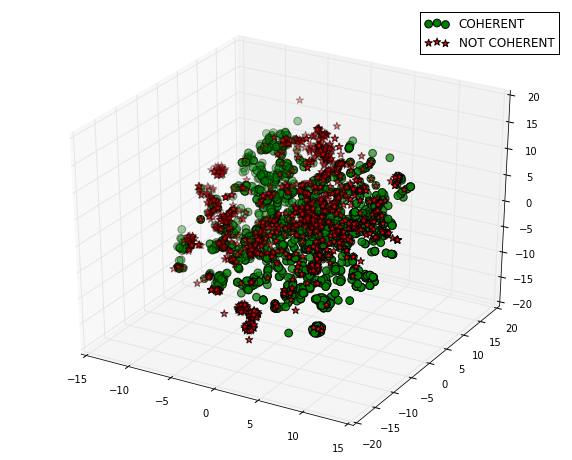

In [32]:
scatter_3D(X_tsne_3d, pos_offset, class_labels)

# Interactive Plots for further Data Exploration


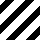
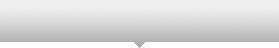
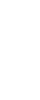
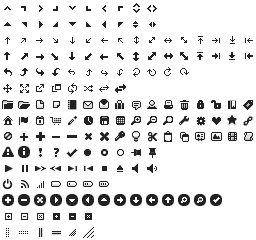
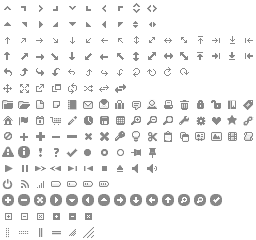
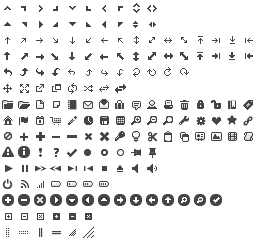
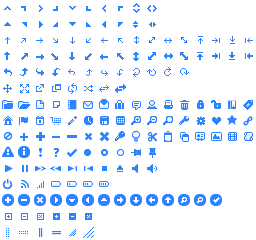
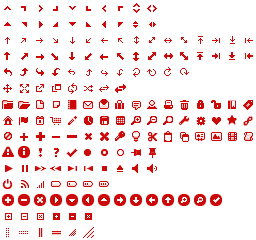
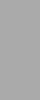
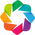
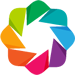
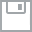
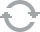
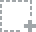
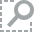
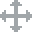
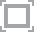
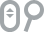

In [34]:
from bokeh.plotting import output_notebook
output_notebook()

In [33]:
from bokeh.plotting import figure, show

def create_interactive_scatter(data, offset, labels):
    """Create an interactive Scatter plot for 
    data separated in two classes.
    
    Parameters
    ----------
    data : list (or numpy array)
        Array of data to plot
        
    offset : integer
        Index of separating classes
        
    Returns
    -------
    p : `bokeh.plotting.figure`
        The Bokeh plotting figure to show
    """
    TOOLS="resize,crosshair,pan,wheel_zoom,box_zoom,reset,tap,previewsave,box_select,poly_select,lasso_select"

    p = figure(tools=TOOLS)
    cl1_label, cl2_label = labels
    p.scatter(data[0:offset,0], data[0:offset,1], color="green", 
              marker='square', label=cl1_label, size=4)
    
    p.scatter(data[offset:,0], data[offset:,1], color='red', 
              marker='circle', label=cl2_label, size=4)
    
    return p

----

### PCA(k=2)

In [35]:
p = create_interactive_scatter(X_PCA2, pos_offset, class_labels)
show(p)

### Isomap

In [37]:
p = create_interactive_scatter(X_Isomap_2d, pos_offset, class_labels)
show(p)

### t-SNE

In [36]:
p = create_interactive_scatter(X_tsne_2d, pos_offset, class_labels)
show(p)